<a href="https://colab.research.google.com/github/bkrant/DS3-Predictive-Modeling-Challenge/blob/master/WaterPump_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install category_encoders
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test_features.csv to test_features.csv
Saving train_features.csv to train_features.csv
Saving train_labels.csv to train_labels.csv


In [0]:
test_features = pd.read_csv('test_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')
df_train_features = pd.read_csv('train_features.csv')
df = pd.merge(df_train_features, df_train_labels, how='inner', on='id')

In [60]:
def wrangle(X):  
  X = X.copy()  
  X = X.set_index('id')
  for feature in ['gps_height', 'population', 'amount_tsh', 'construction_year']:
    X[feature].replace(0.0, np.nan, inplace=True)
  nan_list = ['0','not known','unknown','none','-','##','not kno','unknown installer']
  X = X.replace(nan_list, np.nan)  
  X['amount_tsh'].fillna(X.groupby(['region'])['amount_tsh'].transform('median'), inplace=True)
  X['construction_year'].fillna(X.groupby(['region'])['construction_year'].transform('median'), inplace=True)
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])
  X['years_service'] = X.date_recorded.dt.year - X.construction_year
  X = X.drop(columns=['quantity_group', 'waterpoint_type_group', 'source_type', 'payment_type', 'extraction_type_class', 
                      'extraction_type', 'longitude', 'latitude', 'date_recorded', 'construction_year', 'district_code'])
  return X

test_features = wrangle(test_features)
df = wrangle(df)
df_train_features.shape, df_train_labels.shape, df.shape

((59400, 40), (59400, 2), (59400, 30))

In [0]:
X = df.drop(columns=['status_group'])
y = df['status_group']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42, train_size=0.8)

In [27]:
df.isna().sum()

amount_tsh               12115
funder                    4445
gps_height               20438
installer                 4482
wpt_name                  3588
num_private                  0
basin                        0
subvillage                 372
region                       0
region_code                  0
lga                          0
ward                         0
population               21381
public_meeting           59400
recorded_by                  0
scheme_management         3878
scheme_name              28843
permit                   59400
extraction_type_group        0
management                 561
management_group           561
payment                   8157
water_quality             1876
quality_group             1876
quantity                   789
source                      66
source_class               278
waterpoint_type              0
status_group                 0
years_service            12115
dtype: int64

In [31]:
df_train_features.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [0]:
df.describe(exclude='number')

,funder,installer,wpt_name,basin,subvillage,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type_group,management,management_group,payment,water_quality,quality_group,quantity,source,source_class,waterpoint_type,status_group
count,55765,55745,59400,59400,59029,59400,59400,56066,59400,55523,31234,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,1897,2145,37400,9,19287,125,2092,2,1,12,2696,2,13,12,5,7,8,6,5,10,3,7,3
top,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,vwc,user-group,never pay,soft,good,enough,spring,groundwater,communal standpipe,functional
freq,9084,17402,3563,10248,508,2503,307,51011,59400,36793,682,38852,26780,40507,52490,25348,50818,50818,33186,17021,45794,28522,32259


In [32]:
df.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [34]:
y_train.value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [0]:
y_val.value_counts(normalize=True)

functional                 0.540067
non functional             0.386700
functional needs repair    0.073232
Name: status_group, dtype: float64

In [0]:
pd.Series(y_pred).value_counts(normalize=True)

functional        0.699889
non functional    0.300111
dtype: float64

In [69]:
plt.figure(figsize=(5,3))

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

Validation accuracy: 0.6796296296296296 Train accuracy: 0.6784722222222223


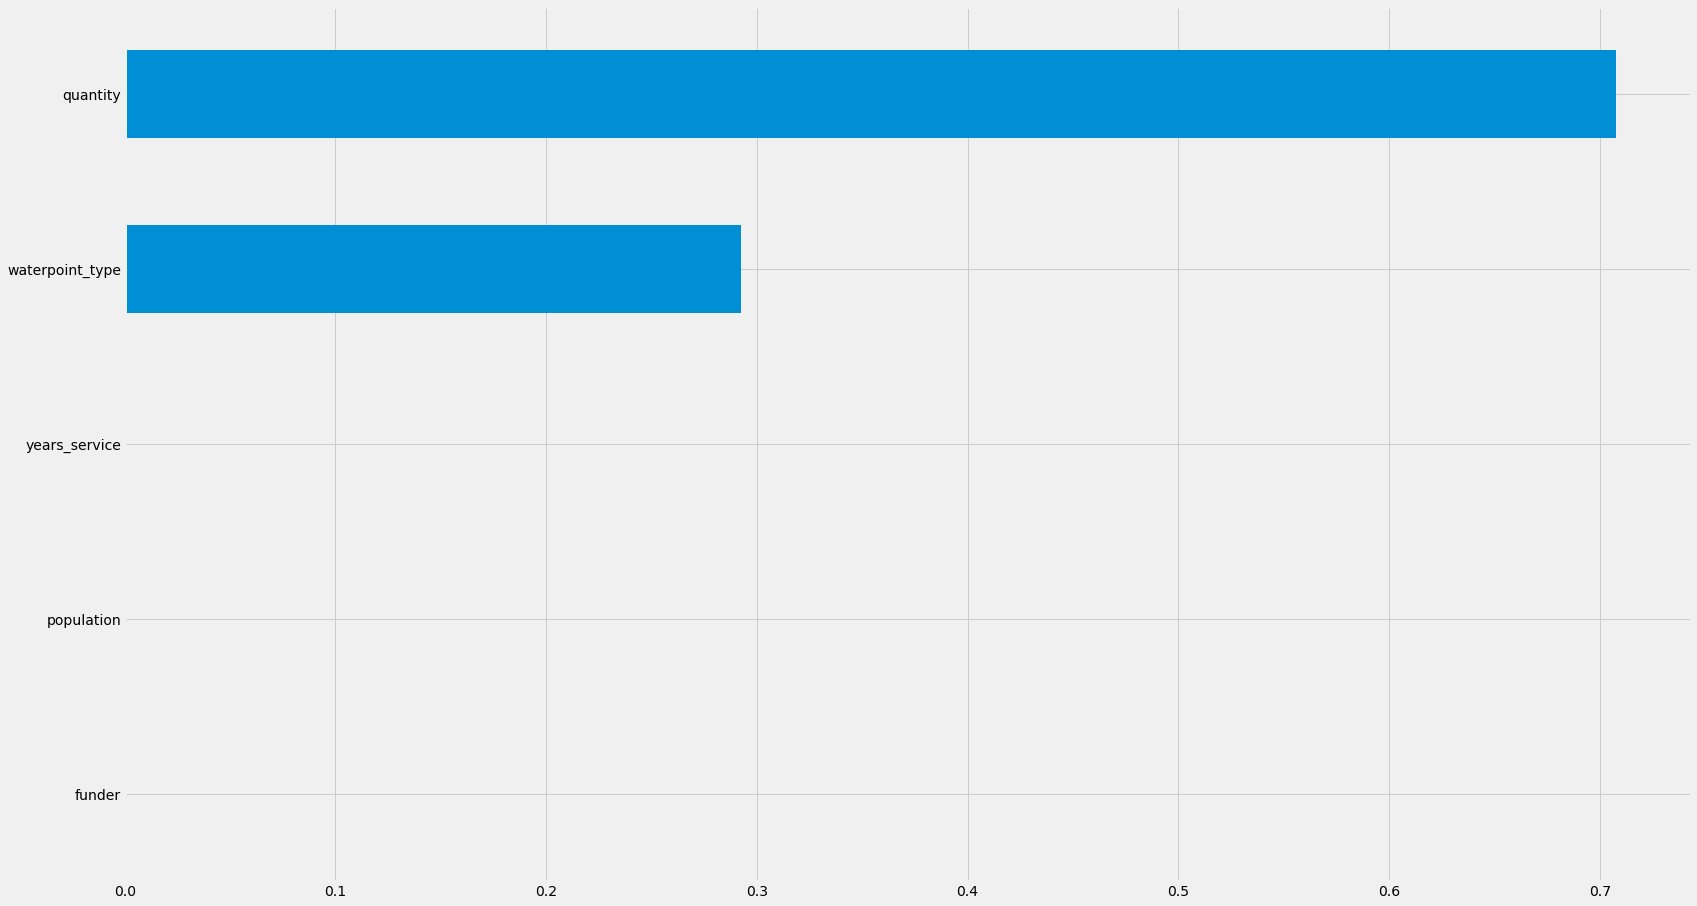

In [71]:
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),  
    DecisionTreeClassifier(max_depth=2, class_weight=None)
)

pipe.fit(X_train, y_train)
print('Validation accuracy:' ,pipe.score(X_val, y_val), 'Train accuracy:', pipe.score(X_train, y_train))
pd.Series(pipe.named_steps.decisiontreeclassifier.feature_importances_, X_train.columns).sort_values(ascending=True).tail().plot(kind='barh');

In [74]:
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),  
    XGBClassifier(n_jobs=-1, class_weight=None, n_estimators=150, max_depth=7, verbose=10, random_state=42, 
                  objective = 'multi:softmax', num_class = 3, evalmetric = 'merror')
)

pipe.fit(X_train, y_train)
print('Validation accuracy:', pipe.score(X_val, y_val), 'Train accuracy:', pipe.score(X_train, y_train))

Validation accuracy: 0.7930134680134681 Train accuracy: 0.8438131313131313


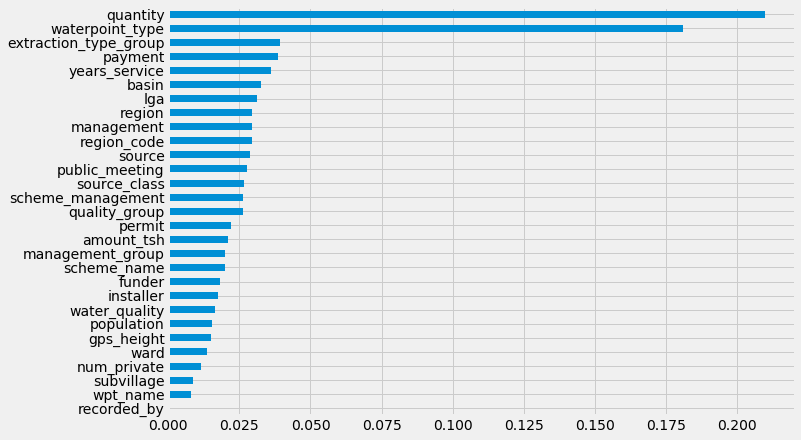

In [75]:
plt.figure(figsize=(10,7))
pd.Series(pipe.named_steps.xgbclassifier.feature_importances_, X_train.columns).sort_values(ascending=True).tail(100).plot(kind='barh');

In [76]:
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),  
    RandomForestClassifier(n_jobs=-1, class_weight=None, n_estimators=100, max_depth=20, random_state=42)
)

pipe.fit(X_train, y_train)
print('Validation accuracy:', pipe.score(X_val, y_val), 'Train accuracy:', pipe.score(X_train, y_train))

Validation accuracy: 0.8026936026936027 Train accuracy: 0.9616582491582492


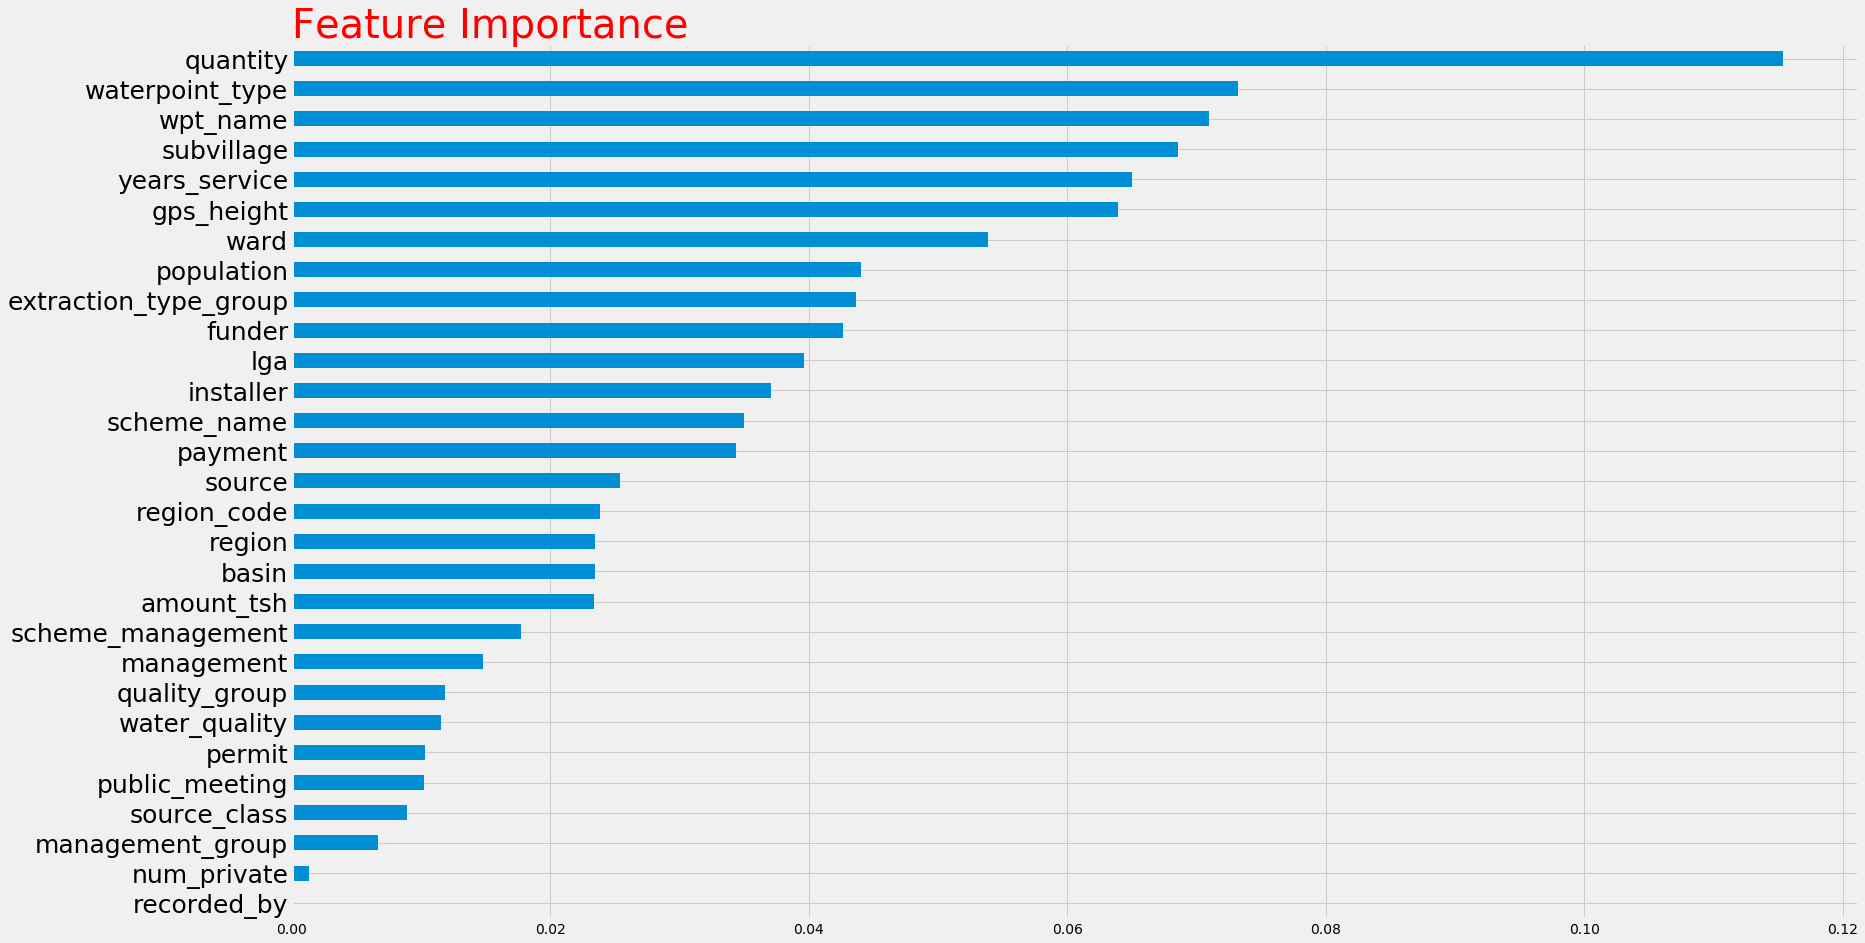

In [0]:
import matplotlib
matplotlib.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(25,15)
plt.title('Feature Importance', loc='left', fontsize=40, color='red')
ax = pd.Series(pipe.named_steps.randomforestclassifier.feature_importances_, X_train.columns).sort_values(ascending=True).tail(100).plot(kind='barh')
for tick in ax.yaxis.get_major_ticks(): #y-axis labels fontsize
  tick.label.set_fontsize(25)

In [0]:
pipe.steps

In [0]:
y_pred = pipe.predict(test_features)

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('rf_no_feature_selection.csv', index=False)
files.download('rf_no_feature_selection.csv')

In [0]:
def cramers_v(x, y):
    import scipy.stats as ss
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [0]:
cramers_v(X_train.quantity, X_train.waterpoint_type)

0.09148719760630807

In [0]:
transformer = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer()
)
X_train_trans = pd.DataFrame(data=transformer.fit_transform(X_train), columns=X_train.columns)
X_val_trans = pd.DataFrame(data=transformer.transform(X_val), columns=X_val.columns)

In [0]:
xgb = XGBClassifier(n_jobs=-1, class_weight=None, n_estimators=150, max_depth=7, verbose=10, random_state=42)
xgb.fit(X_train_trans, y_train)
print('Validation accuracy:', xgb.score(X_val_trans, y_val), 'Train accuracy:', xgb.score(X_train_trans, y_train))

In [78]:
X_train_trans.head(2)

,amount_tsh,funder,gps_height,installer,wpt_name,num_private,basin,subvillage,region,region_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type_group,management,management_group,payment,water_quality,quality_group,quantity,source,source_class,waterpoint_type,years_service
0,599.362936,1.0,1019.312991,1.0,1.0,0.0,1.0,1.0,1.0,12.0,1.0,1.0,280.566034,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.4447
1,500.000000,2.0,2049.000000,2.0,2.0,0.0,2.0,2.0,2.0,11.0,2.0,2.0,175.000000,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0000


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(xgb, scoring='accuracy', cv='prefit', 
                                 n_iter=2, random_state=42)

permuter.fit(X_train_trans, y_train)

In [0]:
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

In [89]:
rf = RandomForestClassifier(n_jobs=-1, class_weight=None, n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train_trans, y_train)
print('Validation accuracy:', rf.score(X_val_trans, y_val), 'Train accuracy:', rf.score(X_train_trans, y_train))

Validation accuracy: 0.8026936026936027 Train accuracy: 0.9616582491582492


In [0]:
permuter = PermutationImportance(rf, scoring='accuracy', cv='prefit', 
                                 n_iter=2, random_state=42)

permuter.fit(X_train_trans, y_train)
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1578 ± 0.0009,quantity
0.0904 ± 0.0004,waterpoint_type
0.0759 ± 0.0005,years_service
0.0697 ± 0.0009,payment
0.0520 ± 0.0011,extraction_type_group
0.0401 ± 0.0004,subvillage
0.0392 ± 0.0006,wpt_name
0.0382 ± 0.0013,gps_height
0.0343 ± 0.0010,ward
0.0340 ± 0.0005,funder


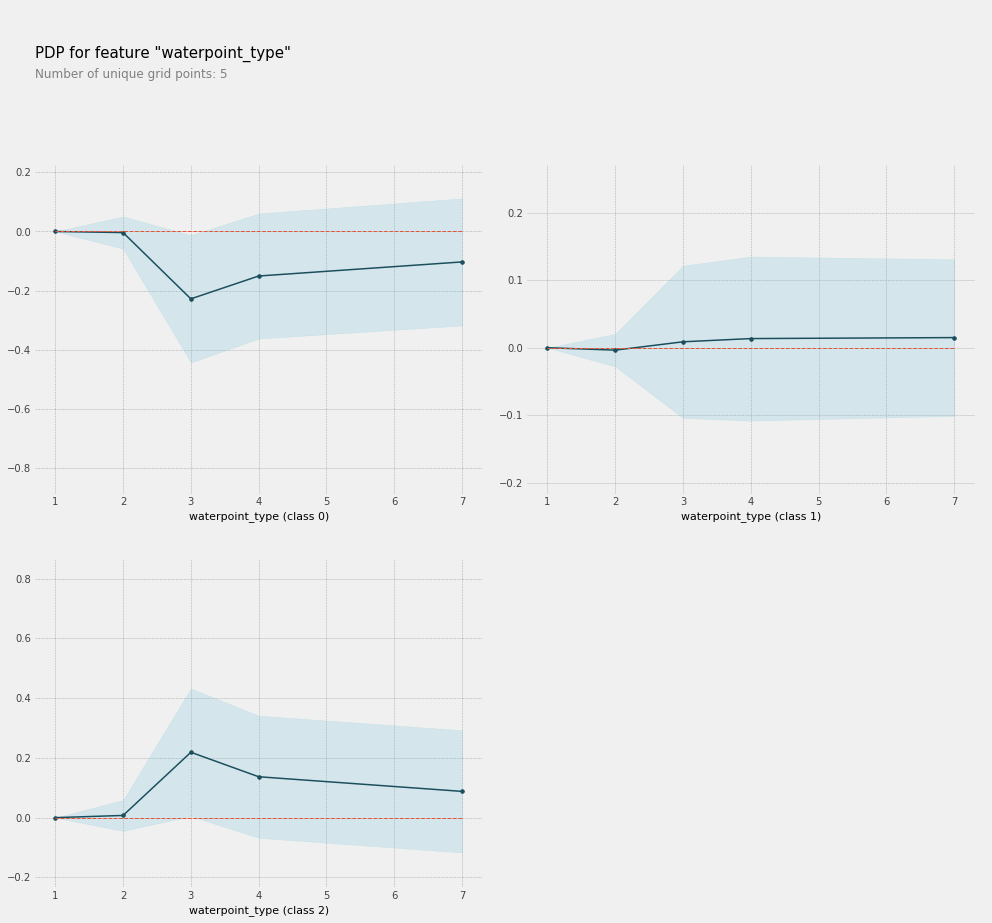

In [90]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'waterpoint_type'

isolated = pdp_isolate(
    model=rf, 
    dataset=X_train_trans, 
    model_features=X_train_trans.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

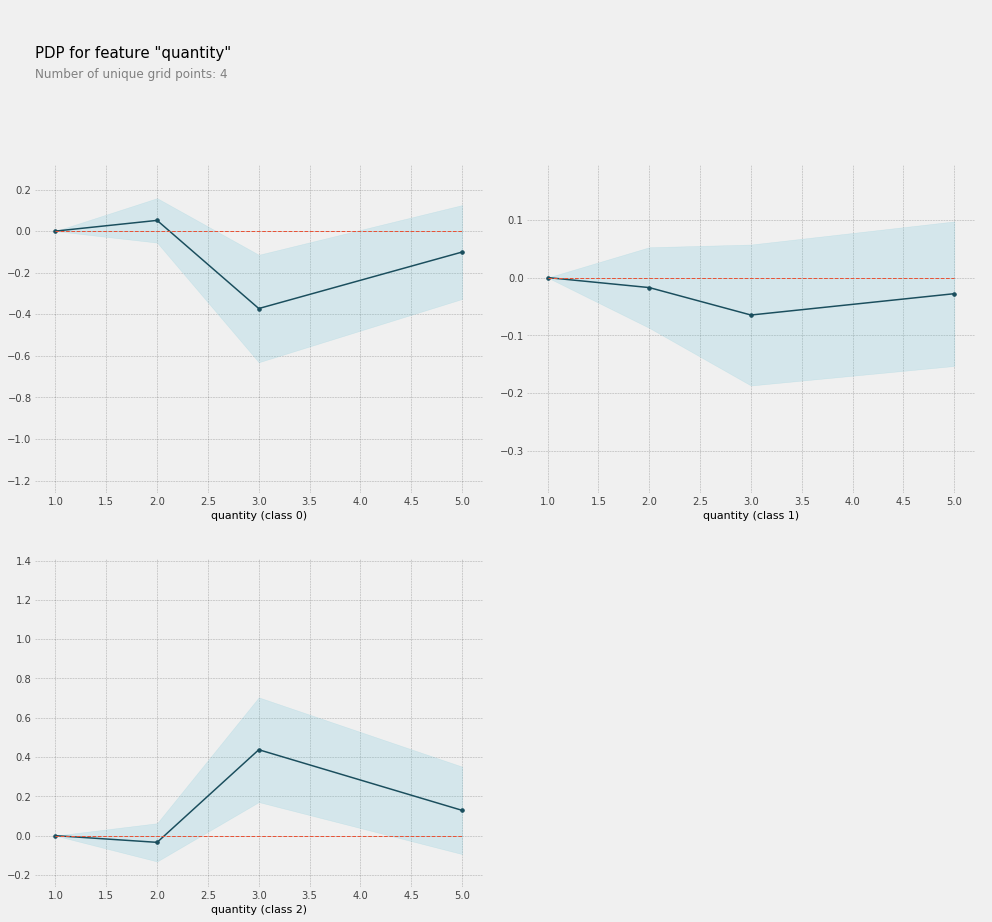

In [91]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'quantity'

isolated = pdp_isolate(
    model=rf, 
    dataset=X_train_trans, 
    model_features=X_train_trans.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [85]:
df.quantity.value_counts() 

enough          33186
insufficient    15129
dry              6246
seasonal         4050
Name: quantity, dtype: int64

In [84]:
X_train_trans.quantity.value_counts()

2.0    26567
1.0    12153
3.0     4921
4.0     3244
5.0      635
Name: quantity, dtype: int64

<Figure size 1440x1440 with 0 Axes>

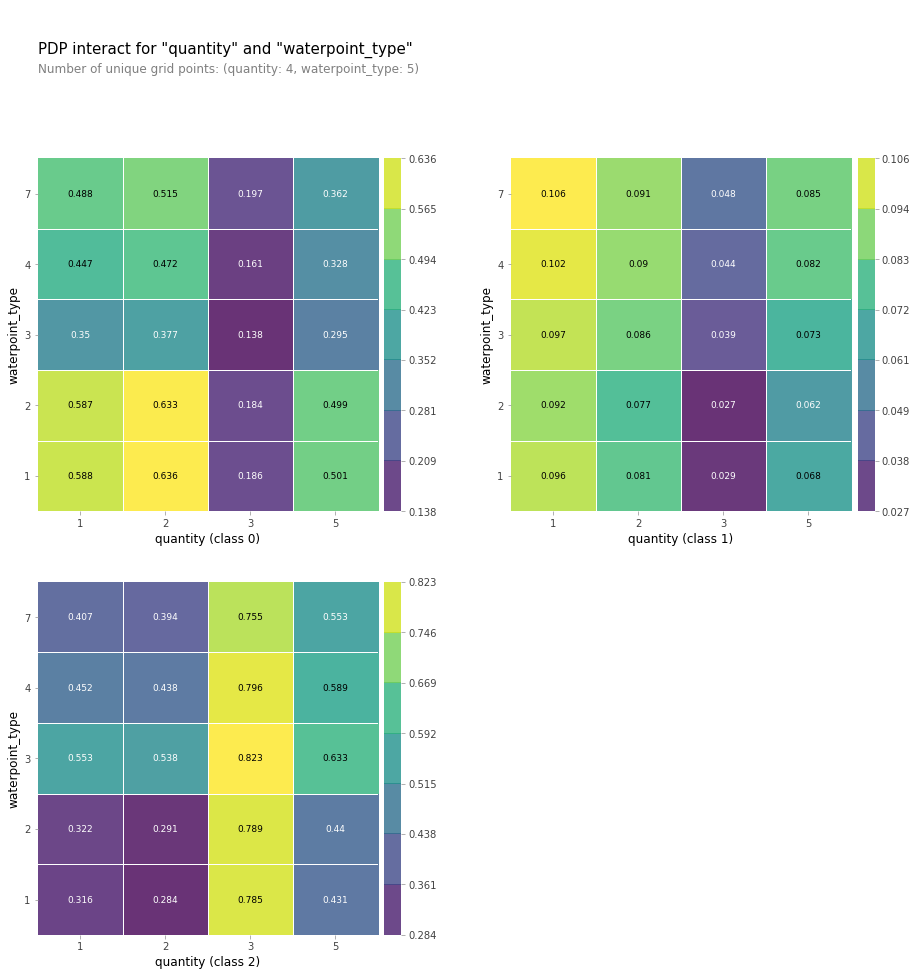

In [21]:
plt.figure(figsize=(20,20));
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['quantity', 'waterpoint_type']

interaction = pdp_interact(
    model=rf, 
    dataset=X_train_trans, 
    model_features=X_train_trans.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);